In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import altair as alt

import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
pd.options.display.float_format = "{:.2f}".format

In [5]:
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

# Explore Transactions Data

In [10]:
df = pd.read_csv("../data/transactions_train.csv").assign(
    t_dat=lambda d: pd.to_datetime(d["t_dat"])
)

In [57]:
df

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.05,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.03,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.02,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.02,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.02,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.06,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.04,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.04,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.01,1


In [75]:
df["t_dat"].nunique()

734

In [12]:
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                   int64
price                      float64
sales_channel_id             int64
dtype: object

In [35]:
df.isna().mean()

t_dat              0.00
customer_id        0.00
article_id         0.00
price              0.00
sales_channel_id   0.00
dtype: float64

In [42]:
df["customer_id"].nunique()

1362281

## Price

<AxesSubplot:ylabel='Frequency'>

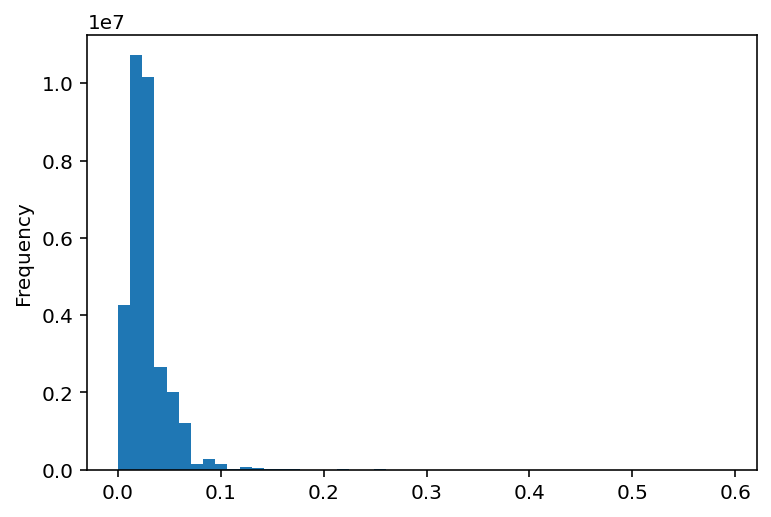

In [34]:
df["price"].plot.hist(bins=50)

In [37]:
df[df["price"] <= 0.0]

,t_dat,customer_id,article_id,price,sales_channel_id


## Sales Channel

<AxesSubplot:>

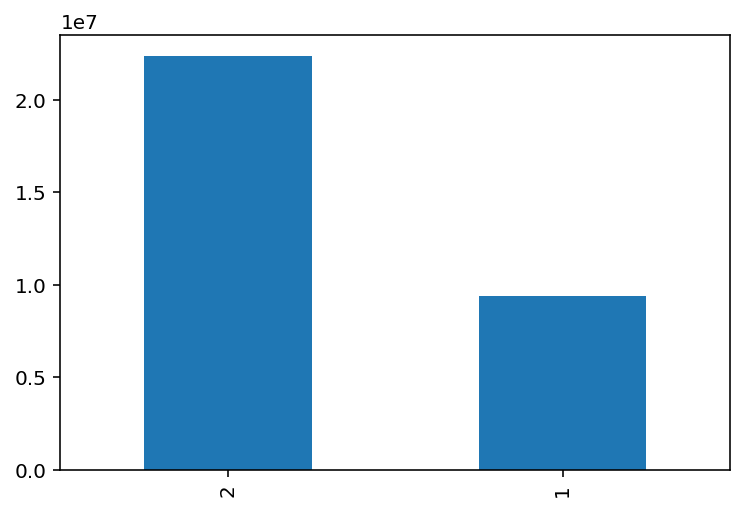

In [41]:
df["sales_channel_id"].value_counts().plot.bar()

## Number of Sales / Unique Customers / Revenue over Time

In [16]:
df["t_dat"].agg(["min", "max"])

min   2018-09-20
max   2020-09-22
Name: t_dat, dtype: datetime64[ns]

In [72]:
df_sales = (
    df.groupby("t_dat")
    .agg(
        num_sales=("article_id", "count"),
        num_unique_customers=("customer_id", "nunique"),
        num_unique_articles=("article_id", "nunique"),
        revenue=("price", "sum"),
    )
    .reset_index()
)

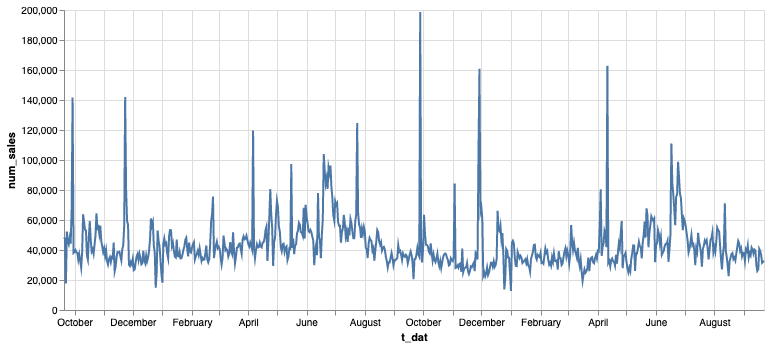

In [31]:
alt.Chart(df_sales).mark_line().encode(
    x="t_dat", y="num_sales", tooltip=["t_dat"]
).properties(width=700)

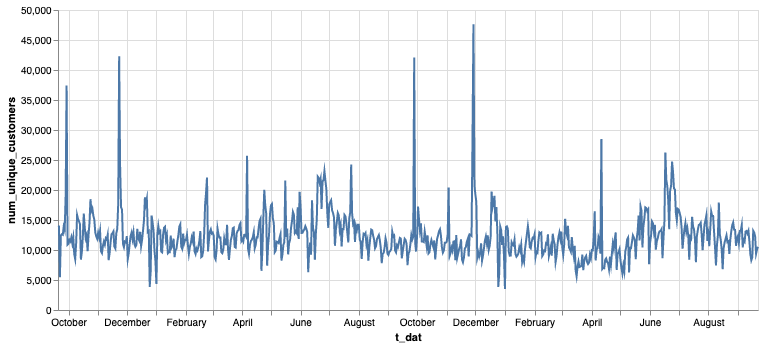

In [32]:
alt.Chart(df_sales).mark_line().encode(
    x="t_dat", y="num_unique_customers", tooltip=["t_dat"]
).properties(width=700)

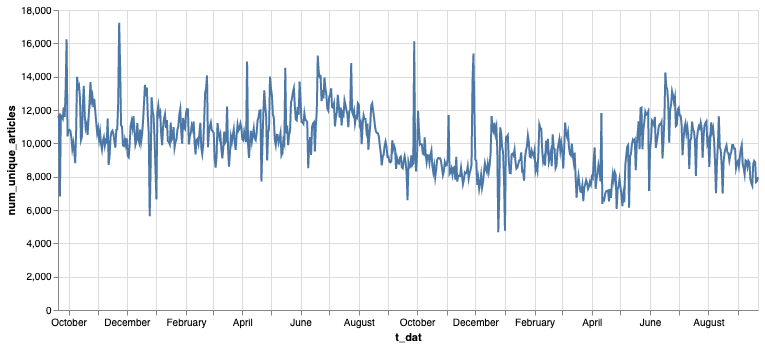

In [73]:
alt.Chart(df_sales).mark_line().encode(
    x="t_dat", y="num_unique_articles", tooltip=["t_dat"]
).properties(width=700)

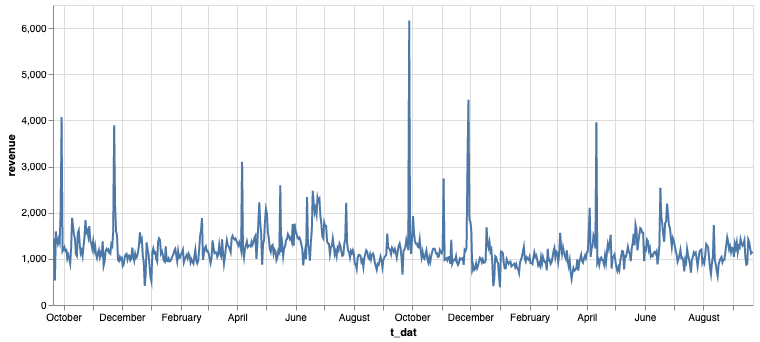

In [33]:
alt.Chart(df_sales).mark_line().encode(
    x="t_dat", y="revenue", tooltip=["t_dat"]
).properties(width=700)

## Customer-Article Sales Relationship

In [52]:
df_customer_sales = df.groupby("customer_id").agg(
    num_sales=("article_id", "count"), num_unique_articles=("article_id", "nunique")
)

In [53]:
df_customer_sales.describe()

,num_sales,num_unique_articles
count,1362281.00,1362281.00
mean,23.33,20.04
std,39.24,31.98
min,1.00,1.00
25%,3.00,3.00
50%,9.00,8.00
75%,27.00,24.00
max,1895.00,1346.00


<AxesSubplot:title={'center':'Number of Unique Articles'}, ylabel='Frequency'>

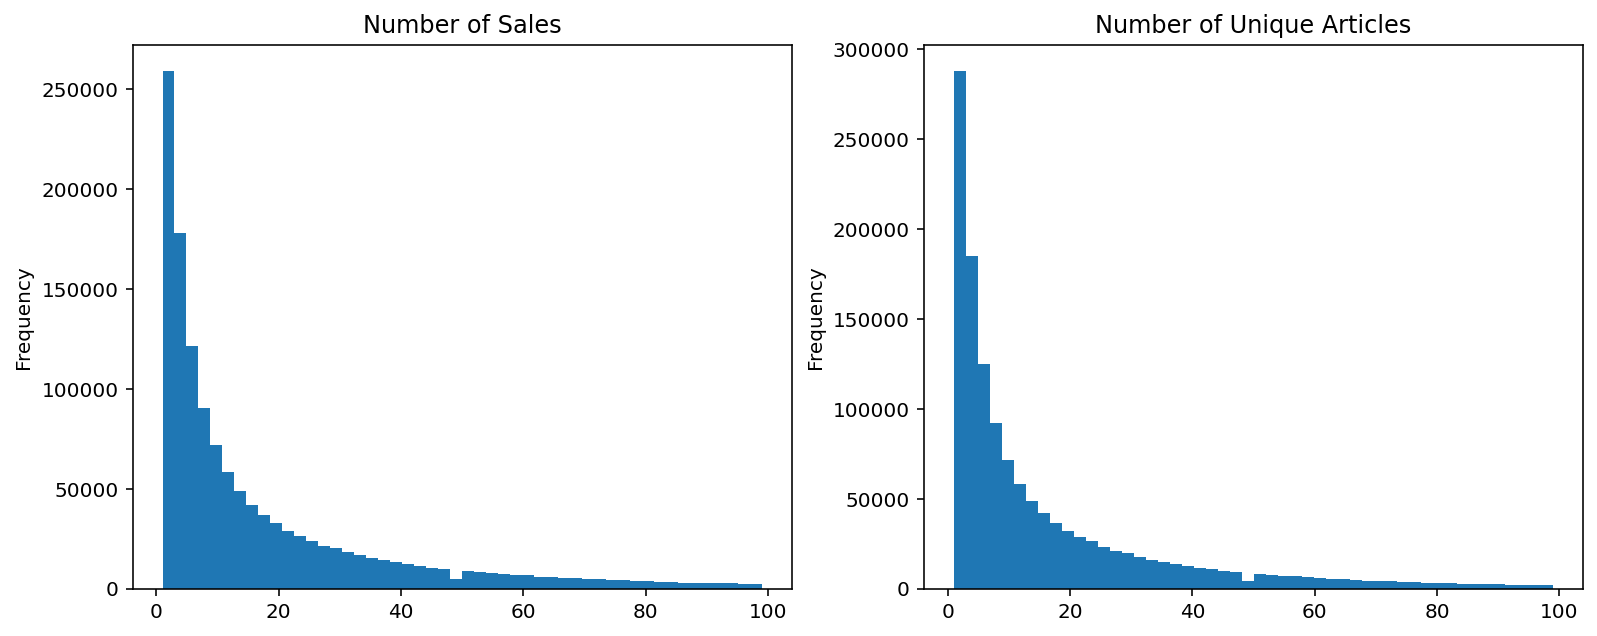

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

df_customer_sales["num_sales"][lambda d: d < 100].plot.hist(
    bins=50, ax=axs[0], title="Number of Sales"
)
df_customer_sales["num_unique_articles"][lambda d: d < 100].plot.hist(
    bins=50, ax=axs[1], title="Number of Unique Articles"
)

## Article-Customer Relationship

In [58]:
df_article_customer = df.groupby("article_id").agg(
    num_unique_customers=("customer_id", "nunique")
)

In [63]:
df_article_customer.describe()

,num_unique_customers
count,104547.00
mean,261.19
std,637.91
min,1.00
25%,12.00
50%,58.00
75%,250.00
max,32251.00


<AxesSubplot:ylabel='Frequency'>

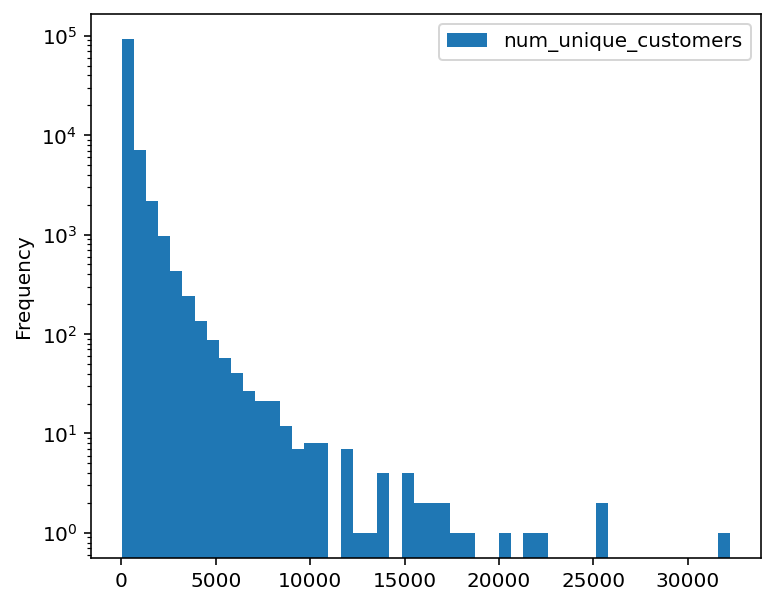

In [68]:
df_article_customer.plot.hist(bins=50, log=True, figsize=(6, 5))

In [71]:
df_article_customer.sort_values("num_unique_customers", ascending=False).head(3)

,num_unique_customers
article_id,
706016001,32251
372860001,25559
706016002,25485


## Training Data Draft

In [77]:
START_TRAIN_DATE = "2018-09-20"
END_TRAIN_DATE = "2020-03-31"
START_TRAIN_LABELS_DATE = "2020-04-01"
END_TRAIN_LABELS_DATE = "2020-04-07"
START_VAL_LABELS_DATE = "2020-04-08"
END_VAL_LABELS_DATE = "2020-04-14"

In [85]:
df_train_feat = df[lambda d: d["t_dat"] <= END_TRAIN_DATE]

In [95]:
df_train_ground_truth = df[
    lambda d: (d["t_dat"] >= START_TRAIN_LABELS_DATE)
    & (d["t_dat"] <= END_TRAIN_LABELS_DATE)
]

In [111]:
df_feat_price_affinity = (
    df_train_feat.groupby("customer_id")
    .agg(price_affinity=("price", "median"))
    .reset_index()
)

<AxesSubplot:ylabel='Frequency'>

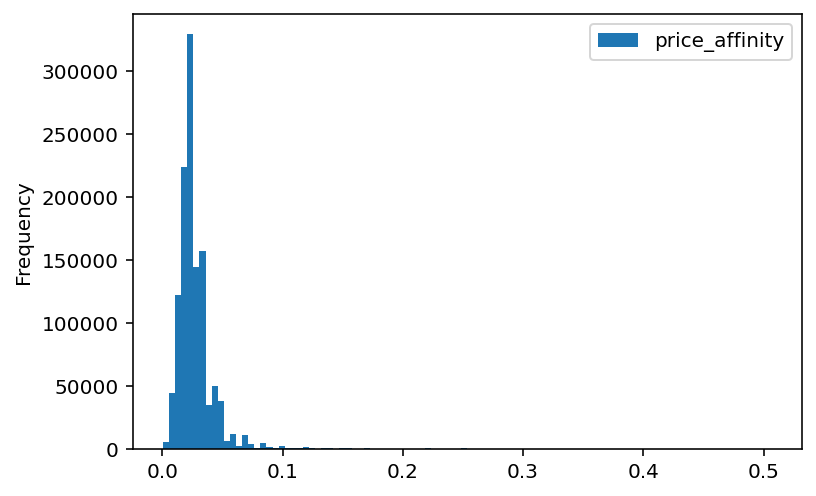

In [112]:
df_feat_price_affinity.plot.hist(y="price_affinity", bins=100)

In [113]:
df_train_ground_truth["t_dat"].dt.dayofweek

23934157    2
23934158    2
23934159    2
23934160    2
23934161    2
           ..
24271435    1
24271436    1
24271437    1
24271438    1
24271439    1
Name: t_dat, Length: 337283, dtype: int64

In [115]:
df_train_ground_truth.merge(
    df_feat_price_affinity, on="customer_id", how="left"
).assign(
    label=1,
    dayofweek=lambda d: d["t_dat"].min().dayofweek,
    month=lambda d: d["t_dat"].min().month,
)[
    ["customer_id", "price_affinity", "price", "dayofweek", "month", "label"]
]

,customer_id,price_affinity,price,dayofweek,month,label
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.03,0.07,2,4,1
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.03,0.07,2,4,1
2,000563485cbb7850b0a93c6606f89c5b961c6647d1bd48...,0.02,0.04,2,4,1
3,000563485cbb7850b0a93c6606f89c5b961c6647d1bd48...,0.02,0.04,2,4,1
4,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,0.02,0.02,2,4,1
...,...,...,...,...,...,...
337278,fffc04eab174fa4aff0f96a64bc3cbd69755fa02b6a7f8...,0.02,0.03,2,4,1
337279,fffc04eab174fa4aff0f96a64bc3cbd69755fa02b6a7f8...,0.02,0.01,2,4,1
337280,fffc04eab174fa4aff0f96a64bc3cbd69755fa02b6a7f8...,0.02,0.03,2,4,1
337281,fffc04eab174fa4aff0f96a64bc3cbd69755fa02b6a7f8...,0.02,0.02,2,4,1
